In [1]:
### dependencies ###
# !pip install cvxpy
# !pip install mystic

In [2]:
%matplotlib inline

# import cvxpy as cp
import numpy as np

import scipy.optimize as opt

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# # verify runway plot

# t_sim = 10 # seconds

# center_line_x = np.zeros((t_sim,))
# left_boundary_x = np.ones((t_sim,)) * -10
# right_boundary_x = np.ones((t_sim)) * 10

# center_line_y = np.linspace(0, t_sim, t_sim)
# left_boundary_y = np.linspace(0, t_sim, t_sim)
# right_boundary_y = np.linspace(0, t_sim, t_sim)

# plt.figure(figsize=(20, 3))
# plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
# plt.plot(left_boundary_y, left_boundary_x, color='black')
# plt.plot(right_boundary_y, right_boundary_x, color='black')

In [4]:
### function to plot trajectory ###

def plot_trajectory(states, runway_length=(-100, 100), runway_boundaries=(-10, 10)):
    runway_direction = -90

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, h, _, _ = states[i:i+6]
        plt.plot(y, x, marker=(3, 0, runway_direction + h), markersize=10, color=colors[int(i//6)])
        

### print states after getting result ###
        
def print_states(states):
    for i in range(0, len(states), 6):
        print("state {}:".format(int(i//6) + 1))
        output_states = np.round(states[i:i+6], 5)
        print("\tx: {}, y: {}, velocity: {}, heading: {}\n\tacceleration: {}, angular velocity: {}\n".\
              format(output_states[0], output_states[1], output_states[2], output_states[3], 
                     output_states[4], output_states[5]))

In [31]:
### states setup ###

init_heading = 0 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0

# want to end here at t = sim_time
desired_x = 0
desired_y = 1

desired_velocity = 1 # m/s

# acceleration_constraint = 10 # m/s^2
# turning_constraint = 5 # degrees

time_step = 0.5
sim_time = 5

n_variables = 6
guess_range = (0, 3)

In [40]:
def shape_states(variables):
    states = variables[:4]
    controls = np.concatenate(([0, 0], variables[4:6]))
    controls[0] = states[2] * np.cos(np.radians(states[3]))
    controls[1] = states[2] * np.sin(np.radians(states[3]))
    return states, controls


def formulate_objective(desired_x, desired_y, desired_v, state_weight=0.5, control_weight=0.5, 
                        constraint_weight=0.5):
    def objective(params):
        cost = 0
        cost += control_weight * np.linalg.norm(np.vstack([params[4], params[5]]), ord=2) ** 2
        for i in range(6, len(params) - 6, 6):
            px, py, v, h, a, w = params[i:i+6]
            cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += np.linalg.norm([desired_v - v], ord=2) ** 2
        px, py, v, h, a, w = params[-6:]
        cost += state_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
        return cost
    return objective


def formulate_constraints(state0, sim_time, ts=1):
    def dynamic_constraints(params):
        errors = np.zeros((sim_time,))
        states_t, controls_t = shape_states(state0)
        errors[0] = np.linalg.norm(params[:4] - states_t, ord=2)
        
        for i in range(6, len(params), 6):    
            states_t1, controls_t1 = shape_states(params[i:i+6])
            #error[t+1] = norm(x_(t+1) - f(x_t, u_t))
            errors[int(i // 6)] = np.linalg.norm(states_t1 - (states_t + ts * controls_t), ord=2)
            states_t, controls_t = states_t1, controls_t1

        return np.sum(errors)
    return dynamic_constraints


def formulate_guess(state0, sim_time, random_seed=0, ts=1):
    
    guess_a = random.randint(guess_range[0], guess_range[1])
    guess_w = random.randint(guess_range[0], guess_range[1])
    state0_controlled = state0 + [guess_a, guess_w]
    init_state = state0_controlled[:]
    ix, iy, iv, ih, ia, iw = init_state
    
    for _ in range(sim_time - 1):
        
        new_x = ix + ts * iv * np.cos(np.radians(ih))
        new_y = iy + ts * iv * np.sin(np.radians(ih))
        new_v = iv + ts * ia
        new_h = ih + ts * iw
        guess_a = random.randint(guess_range[0], guess_range[1])
        guess_w = random.randint(guess_range[0], guess_range[1])
        init_state += [new_x, new_y, new_v, new_h, guess_a, guess_w]
        
        ix, iy, iv, ih, ia, iw = new_x, new_y, new_v, new_h, guess_a, guess_w
        
    return state0_controlled, np.array(init_state)
    
    
state0 = [init_x, init_y, init_velocity, init_heading]
state0, init_guess = formulate_guess(state0, sim_time, ts=time_step)

con = formulate_constraints(state0, sim_time, ts=time_step)
obj = formulate_objective(desired_x, desired_y, desired_velocity, state_weight=10, 
                          constraint_weight=1, control_weight=0.5)

result = opt.minimize(obj, init_guess, method='SLSQP', constraints={"fun": con, "type": "eq"}, 
                      options={'eps': 0.01, 'maxiter': 1000})
result

     fun: 6.348580542569637
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -8.04278126e-03, -8.02464943e-03, -4.02325883e-01,  0.00000000e+00,
       -1.20800575e+00,  0.00000000e+00, -7.66338362e-01, -1.21331643e+00,
        1.18171717e-02,  0.00000000e+00, -1.98470943e+00,  0.00000000e+00,
        3.97777587e-01, -7.33061236e-01, -7.72936811e-03,  0.00000000e+00,
       -1.59034584e+00,  0.00000000e+00,  1.53583315e+00, -2.87857358e-01,
        2.79034469e+00, -9.33954494e+00, -2.11111047e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
 message: 'Iteration limit exceeded'
    nfev: 41727
     nit: 1001
    njev: 1001
  status: 9
 success: False
       x: array([-3.67467179e-03, -8.86509798e-03, -4.61948982e-03, -8.59703908e-03,
       -1.30427813e-02, -1.30246494e-02, -2.06162942e-01,  4.89537525e-01,
        3.90997126e-01,  4.12370291e-01, -7.71338362e-01, -1.21831643e+00,
        9.08585865e-04,  5.37876446e-01,  2.64528

errors: [0.         0.6329301  0.00234445 0.00871621 0.04704772] 

state 1:
	x: -0.00367, y: -0.00887, velocity: -0.00462, heading: -0.0086
	acceleration: -0.01304, angular velocity: -0.01302

state 2:
	x: -0.20616, y: 0.48954, velocity: 0.391, heading: 0.41237
	acceleration: -0.77134, angular velocity: -1.21832

state 3:
	x: 0.00091, y: 0.53788, velocity: 0.00265, heading: -0.19601
	acceleration: 0.39278, angular velocity: -0.73806

state 4:
	x: -0.00886, y: 0.63056, velocity: 0.19983, heading: -0.56576
	acceleration: 1.53083, angular velocity: -0.29286

state 5:
	x: 0.04272, y: 0.84094, velocity: 0.95941, heading: -0.71401
	acceleration: 1.0, angular velocity: 1.0



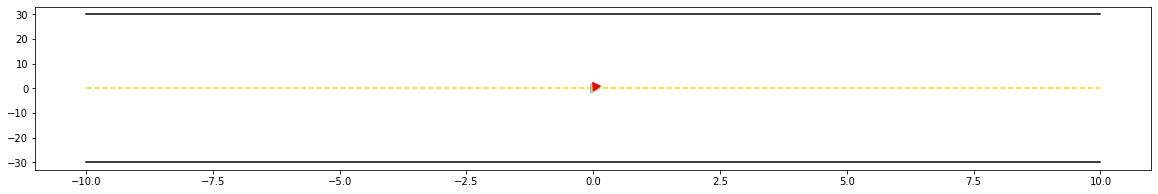

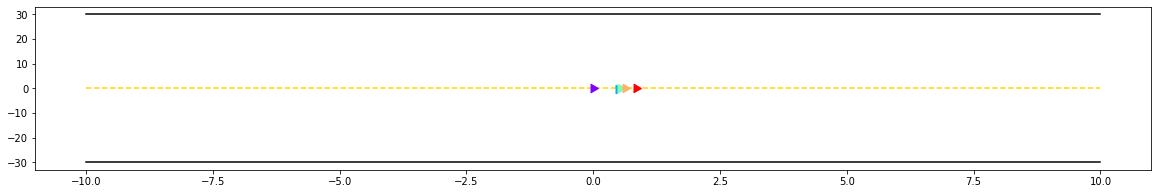

In [41]:
def get_controls(variables):
    controls = []
    for i in range(0, len(variables), 6):
        controls.append(variables[i+4])
        controls.append(variables[i+5])
    return controls

### verification for constraints ###

def verify_output(state0, params, sim_time, ts=1):
    errors = np.zeros((sim_time,))
    init_states, init_controls = shape_states(params[:6])
    errors[0] = np.linalg.norm(params[:4] - init_states, ord=2) ** 2

    for i in range(6, len(params), 6):    
        next_states, next_controls = shape_states(params[i:i+6])
        errors[int(i // 6)] = np.linalg.norm(next_states - (init_states + ts * init_controls), ord=2) ** 2
        init_states, init_controls = next_states, next_controls

    return errors

print("errors:", verify_output(state0, result.x, sim_time, ts=time_step), "\n")

plot_trajectory(init_guess, runway_length=(-10, 10), runway_boundaries=(-30, 30))
plot_trajectory(result.x, runway_length=(-10, 10), runway_boundaries=(-30, 30))
        
print_states(result.x)